In [1]:
!pip install xgboost 
!pip install torch


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
test_data = pd.read_csv('medical_test.csv')
train_data = pd.read_csv('medical_train.csv')
validation_data = pd.read_csv('medical_validate.csv')

train_data = train_data.drop(columns=['index'])
test_data = test_data.drop(columns=['level_0','index'])
validation_data = validation_data.drop(columns = ['level_0','index'])

print (train_data.shape, validation_data.shape,test_data.shape)

(6000, 9) (2000, 9) (2000, 9)


In [4]:
for column in ('Sex~male','Smoker~yes', 'Region~northwest','Region~southeast', 'Region~southwest'):
    test_data[column] = test_data[column].astype(int)
    train_data[column] = train_data[column].astype(int)
    validation_data[column] = validation_data[column].astype(int)


dataframes = [train_data, test_data, validation_data]

for i, dataframe in enumerate(dataframes):
    dataframes[i] = dataframe.rename(columns={
        'Medical Cost': 'Medical_Cost',
        'Sex~male': 'Sex_male',
        'Smoker~yes': 'Smoker_yes',
        'Region~northwest': 'Region_northwest',
        'Region~southeast': 'Region_southeast',
        'Region~southwest': 'Region_southwest'})

train_data, test_data, validation_data = dataframes

In [5]:
train_data

,Age,BMI,Children,Medical_Cost,Sex_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
0,0.042553,0.772,0.0,0.768239,1,1,0,0,0
1,0.617021,0.164,0.4,0.865271,0,1,0,1,0
2,0.574468,0.360,0.2,0.138651,0,0,0,0,0
3,0.148936,0.628,1.0,0.116429,1,0,0,0,0
4,0.617021,0.952,1.0,0.204466,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
5995,0.148936,0.452,1.0,0.854807,1,1,0,0,0
5996,0.127660,0.476,0.4,0.776791,0,1,0,1,0
5997,0.723404,0.924,1.0,0.909439,0,1,1,0,0
5998,0.127660,0.736,0.8,0.111393,1,0,1,0,0


In [6]:
X_train, y_train = train_data.drop('Medical_Cost', axis=1), train_data['Medical_Cost']
X_validate, y_validate = validation_data.drop('Medical_Cost', axis=1), validation_data['Medical_Cost']
X_test, y_test = test_data.drop('Medical_Cost', axis=1), test_data['Medical_Cost']

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

class SGLBEnsemble:
    def __init__(self, n_estimators = 100, learning_rate=0.1, max_depth=5, subsample=0.8, n_models=5):
        self.models = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.n_models = n_models

    def fit(self, X, y):
        """Fit multiple XGBoost models to the training data."""
        self.models = []
        for _ in range(self.n_models):
            model = XGBRegressor(
                n_estimators=self.n_estimators,
                learning_rate=self.learning_rate,
                max_depth=self.max_depth,
                subsample=self.subsample,
                random_state = np.random.randint(0, 10000)  # Random seed for model diversity
            )
            model.fit(X, y)
            self.models.append(model)

    def predict(self, X):
        """Predict using the ensemble of models and return mean and standard deviation of predictions."""
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0), np.std(predictions, axis=0)

def hyperparameter_tuning(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0]
    }
    
    xgb_model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_

def train_and_predict(X_train, y_train, X_validate, y_validate, X_test, y_test):
    """Train the SGLB ensemble and make predictions on validation and test sets."""
    
    # Hyperparameter tuning to find the best parameters
    best_params = hyperparameter_tuning(X_train, y_train)
    
    model = SGLBEnsemble(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample'],
        n_models=5  # You can also tune this parameter if needed
    )

    print("Fitting SGLB ensemble with optimized parameters...")
    model.fit(X_train, y_train)
    
    val_mean, val_std = model.predict(X_validate)
    test_mean, test_std = model.predict(X_test)
    
    val_mean, val_std = model.predict(X_validate)
    test_mean, test_std = model.predict(X_test)
    
    val_df = validation_data.copy()
    val_df['Mean'] = val_mean
    val_df['Uncertainty'] = val_std
    val_rmse = np.sqrt(mean_squared_error(y_validate, val_mean))

    test_df = test_data.copy()
    test_df['Mean'] = test_mean
    test_df['Uncertainty'] = test_std
    test_rmse = np.sqrt(mean_squared_error(y_test, test_mean))

    return val_df, test_df, val_rmse, test_rmse


In [15]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import random

class SGLBEnsemble:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, n_models=5):
        self.models = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.n_models = n_models

    def fit(self, X, y):
        """Fit multiple XGBoost models to the training data."""
        self.models = []
        for _ in range(self.n_models):
            seed = random.randint(0, 10**6)  # Random seed for diversity
            model = XGBRegressor(
                n_estimators=self.n_estimators,
                learning_rate=self.learning_rate,
                max_depth=self.max_depth,
                subsample=self.subsample,
                random_state=seed
            )
            model.fit(X, y)
            self.models.append(model)

    def predict(self, X):
        """Predict using the ensemble of models and return mean and standard deviation of predictions."""
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0), np.std(predictions, axis=0)


def hyperparameter_tuning(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0]
    }
    
    xgb_model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_


def train_and_predict(X_train, y_train, X_validate, y_validate, X_test, y_test):
    """Train the SGLB ensemble and make predictions on validation and test sets."""
    
    # Hyperparameter tuning to find the best parameters
    best_params = hyperparameter_tuning(X_train, y_train)
    
    model = SGLBEnsemble(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample'],
        n_models=5  # Tune this if needed
    )

    print("Fitting SGLB ensemble with optimized parameters...")
    model.fit(X_train, y_train)
    
    val_mean, val_std = model.predict(X_validate)
    test_mean, test_std = model.predict(X_test)
    
    val_df = validation_data.copy()
    val_df['Mean'] = val_mean
    val_df['Uncertainty'] = val_std
    val_rmse = np.sqrt(mean_squared_error(y_validate, val_mean))

    test_df = test_data.copy()
    test_df['Mean'] = test_mean
    test_df['Uncertainty'] = test_std
    test_rmse = np.sqrt(mean_squared_error(y_test, test_mean))

    return val_df, test_df, val_rmse, test_rmse


In [16]:
val_results, test_results, val_rmse, test_rmse = train_and_predict(X_train, y_train, X_validate, y_validate, X_test, y_test)

Fitting SGLB ensemble with optimized parameters...


In [18]:
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

Validation RMSE: 0.017520312563586445
Test RMSE: 0.01768981164123706


In [19]:
val_results.head()

,Age,BMI,Children,Medical_Cost,Sex_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest,Mean,Uncertainty
0,0.510638,0.368,0.2,0.830299,1,1,0,0,1,0.833655,0.002845
1,0.382979,0.076,0.6,0.101170,1,0,0,0,0,0.108733,0.001659
2,0.808511,0.768,0.0,0.857555,0,1,0,0,0,0.885896,0.001609
3,0.702128,0.892,0.4,0.173010,1,0,0,0,0,0.175655,0.001741
4,0.553191,0.580,0.0,0.109274,1,0,0,0,0,0.123702,0.001153


In [20]:
test_results.head()

,Age,BMI,Children,Medical_Cost,Sex_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest,Mean,Uncertainty
0,0.255319,0.900,0.2,0.824914,1,1,0,0,1,0.823305,0.002579
1,0.000000,0.820,0.2,0.760608,0,1,0,1,0,0.793625,0.001150
2,0.468085,0.848,1.0,0.869827,0,1,0,0,1,0.895684,0.003483
3,0.170213,0.688,0.4,0.818766,1,1,0,0,0,0.807673,0.000827
4,0.914894,0.532,0.4,0.911445,0,1,0,0,1,0.916340,0.001051


In [21]:
def qce(predictions, n_quantiles, n_bins, filename, scale = 1):
  quantiles = np.linspace(0, 1, n_quantiles+1)

  test_predictions = predictions.copy()
  
  test_predictions['Uncertainty'] = scale * test_predictions['Uncertainty']

  df = test_predictions

  # Variance ranges for binning
  cutoffs = np.linspace(df['Uncertainty'].iloc[0],
                        df['Uncertainty'].iloc[len(df)-1],
                        n_bins+1)

  error = 0.0
  observed = []

  # For each confidence level
  for p in quantiles:
    bin_freqs = [0 for _ in range(n_bins)]
    bin_counts = [0 for _ in range(n_bins)]
    i = 0
    # For each prediction
    for j in range(len(df)):
      point = df.iloc[j]
      mu = point['Mean']
      s = point['Uncertainty']
      y = point['Medical_Cost']

      # Place point in appropriate bin
      if s > cutoffs[i+1]:
        i += 1
      bin_counts[i] += 1

      # Calculate confidence interval
      z = stats.norm.ppf((1 + p) / 2)
      if np.abs(mu - y) <= z * s:
        bin_freqs[i] += 1

    freq = [bin_freqs[i]/bin_counts[i] for i,_ in enumerate(bin_freqs)]
    qce = sum(bin_counts[i] * np.abs(freq[i] - p) for i,_ in enumerate(freq))
    empirical = sum(bin_counts[i] * freq[i] for i,_ in enumerate(freq))
    observed.append(empirical / len(df))
    error += (qce / len(df))

  error = error / (n_quantiles+1)

  if filename == None:
    return error

  fig, ax = plt.subplots()
  ax.plot(quantiles, observed, linewidth=2, alpha=.5)
  ax.plot(quantiles, quantiles, linewidth=2, alpha=.5)

  ax.set_xlabel(r'Expected Confidence Level')
  ax.set_ylabel(r'Observed Confidence Level')
  ax.grid()

  plt.savefig(filename)
  return error


In [26]:
# figure out scale value
def calibrate(predictions_gp):
    for i in np.linspace(13, 17, num = 20):
        print(i, end="   ")
        print(qce(predictions_gp, 10, 10, None, i))

0.0999090909090909

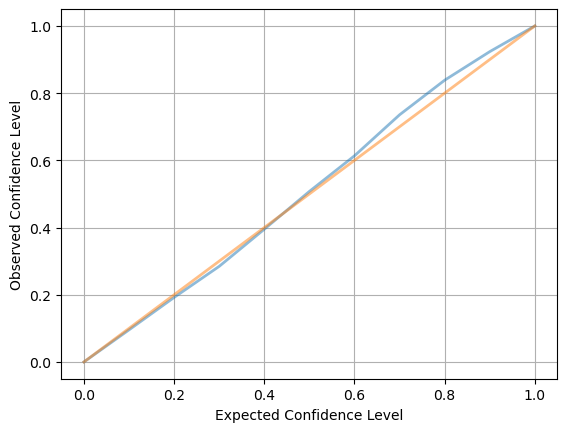

In [28]:
predictions_gp = val_results[['Medical_Cost', 'Mean', 'Uncertainty']]
predictions_gp

predictions_gp = predictions_gp.sort_values('Uncertainty')

qce(predictions_gp, 10, 10, "gp_calibration_plot", scale = 14.894736842105264 )

# calibrate(predictions_gp)

0.3815909090909091

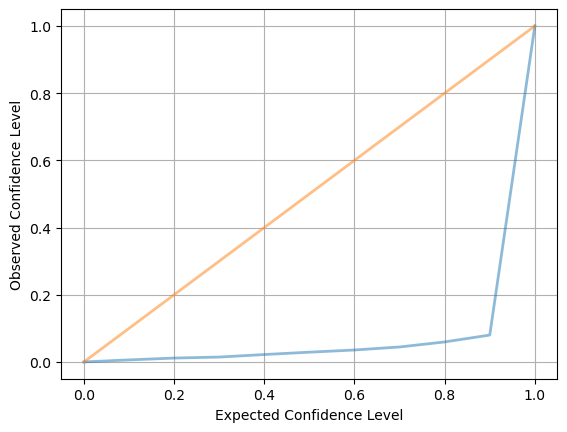

In [29]:
predictions_gp = val_results[['Medical_Cost', 'Mean', 'Uncertainty']]
predictions_gp

predictions_gp = predictions_gp.sort_values('Uncertainty')

qce(predictions_gp, 10, 10, "gp_calibration_plot", scale = 1)

In [30]:
# figure out scale value
def calibrate(predictions_gp):
    for i in np.linspace(1,20, num = 20):
        print(i, end="   ")
        print(qce(predictions_gp, 10, 10, None, i))

0.10025454545454547

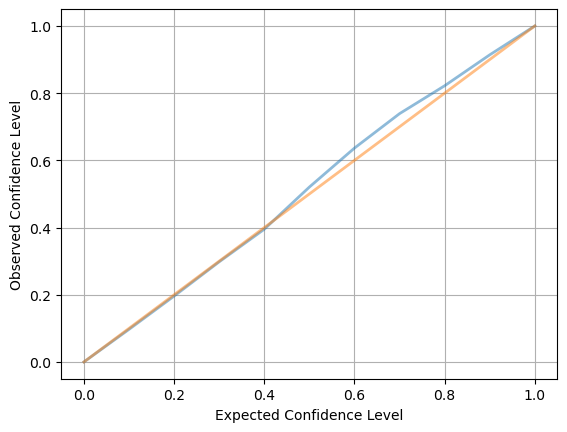

In [31]:
predictions_gp = test_results[['Medical_Cost', 'Mean', 'Uncertainty']]
predictions_gp

predictions_gp = predictions_gp.sort_values('Uncertainty')

qce(predictions_gp, 10, 10, "gp_calibration_plot", scale = 14.894736842105264 )